# ex-11 Produce Climate Zone Temporal_curve_24hr using HIRDS data

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd 
import xarray as xr
import rioxarray as rx
import geopandas as gpd
import matplotlib.pyplot as plt
from temporal_curve import temporal_curve_24hr
%matplotlib inline

## 1. Prepare data

The key idea is to use a climate zone polygon to cut the country-level DDFs, and then to calculate spatial mean.

***Note:***
- The shapefile and the spatial DDF data must have the same spatial projection.
- In HIRDS, the default projection is epsg:4326
- For Auckland Shapefile, the default projection is epsg:4326
- ***It is easier to transform projections for shapefile***

### 1.1 Read climate zone shapefile

![cz](data/climatezones.png)

In [2]:
gdf_nz = gpd.read_file("data/NZ_ClimateZone/NZClimate.shp")
gdf_nz

,Shape_Leng,Shape_Area,CZ,geometry
0,19.853261,6.903691,ESI,"MULTIPOLYGON (((172.69896 -43.63224, 172.68986..."
1,45.386298,8.176955,WSI,"MULTIPOLYGON (((167.39786 -47.25784, 167.39576..."
2,21.293166,2.204193,NSI,"MULTIPOLYGON (((173.17846 -41.29894, 173.17636..."
3,10.907627,3.041842,WNI,"MULTIPOLYGON (((174.78036 -41.09934, 174.77226..."
4,18.040459,3.195582,ENI,"MULTIPOLYGON (((177.86326 -39.30804, 177.86066..."
5,43.263371,5.819416,NNI,"MULTIPOLYGON (((176.97606 -37.85714, 176.96996..."


#### We take the climate zone of "NNI" as an example

- Index for "NNI" is 5
- covers the Auckland

<Axes: >

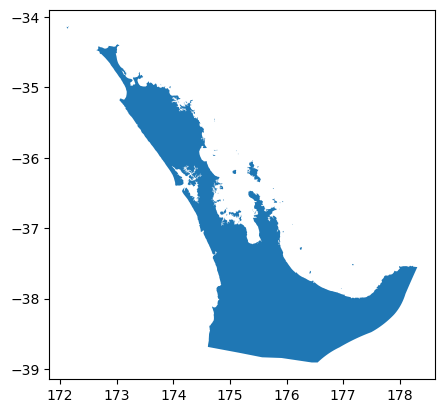

In [3]:
gdf_auk = gdf_nz.iloc[[5]]
gdf_auk.plot()

### 1.2 Read HIRDS v4 data
- taking ARI=100a as an example
- make HIRDs have the same spatial projection as shapefile

In [4]:
ARI = 100 # in years

data_file = r"data/New Zealand_Extreme_Precipitation_baseline_NIWA.nc"
da_ddfs_100a = xr.open_dataset(data_file)['Extreme_Precipitation'].sel(
    ARI=ARI).drop(["ARI"]).rename({"lat": "latitude", "lon":"longitude"})

da_ddfs_100a.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'Extreme_Precipitation' (Hrs: 12, latitude: 700,
                                           longitude: 750)>
[6300000 values with dtype=float32]
Coordinates:
  * Hrs          (Hrs) float64 0.1667 0.3333 0.5 1.0 ... 48.0 72.0 96.0 120.0
  * latitude     (latitude) float64 -34.02 -34.04 -34.06 ... -47.96 -47.98 -48.0
  * longitude    (longitude) float64 165.0 165.0 165.0 ... 179.9 180.0 180.0
    spatial_ref  int32 0
Attributes:
    units:       mm
    regenerate:  http://www.climsystems.com J.Yu 2021-05-15

### 1.3 Calculate sptial mean and transform to pandas.dataframe

In [5]:
# clip and spatial mean
da_auk = da_ddfs_100a.rio.clip(gdf_auk.geometry.values, gdf_auk.crs)
da_auk_m = da_auk.mean(dim=['latitude', "longitude"]).drop("spatial_ref")

# to dataframe
df_ddfs = da_auk_m.to_dataframe().rename({"Extreme_Precipitation" : "ddf"}, axis=1)

# convert duration from hours to minutes
df_ddfs.index = np.round(df_ddfs.index*60, 4)
df_ddfs.index.name = "mins"
df_ddfs

,ddf
mins,
10.0,23.739862
20.0,34.237934
30.0,42.192894
60.0,59.652916
120.0,83.000206
360.0,134.623901
720.0,177.201965
1440.0,226.793335
2880.0,281.076324


## 2. Calculate temporal curve

- using all durations

In [6]:
df_crrs_auk_m = temporal_curve_24hr(df_ddfs)

### Visualization

Text(0.5, 1.0, 'Temporal Curve for duration=24 hours and ARI=100a')

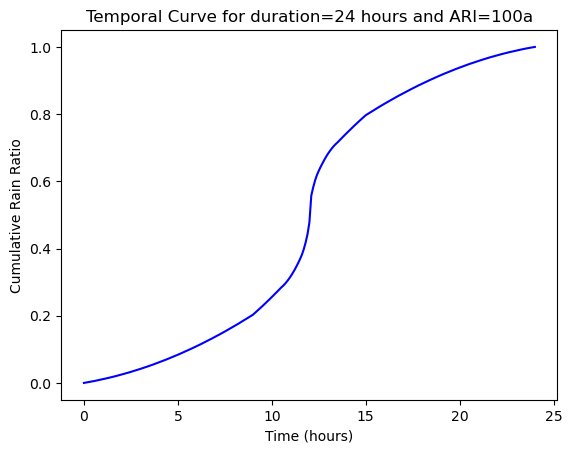

In [7]:
df_crrs_auk_m.plot(color='b', legend=False)
plt.xlabel("Time (hours)")
plt.ylabel("Cumulative Rain Ratio")
plt.title("Temporal Curve for duration=24 hours and ARI=100a")

## 3. A Little More 

In [8]:
df_crrs_auk_m.rename({"crr": "Cumulative Rain Ratio"}, axis=1)

,Cumulative Rain Ratio
hours,
0.0,0.000
0.1,0.001
0.2,0.002
0.3,0.003
0.4,0.004
...,...
23.6,0.996
23.7,0.997
23.8,0.998


- ***Convert to real precipitation depth (mm)***

In [9]:
df_crrs_auk_m * df_ddfs.loc[1440].values 

,crr
hours,
0.0,0.000000
0.1,0.226793
0.2,0.453587
0.3,0.680380
0.4,0.907173
...,...
23.6,225.886162
23.7,226.112955
23.8,226.339748
